In [1]:
import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('D:/Papers/paper_code/new/Data/Processed/Gold_data.csv')

In [3]:
data.head()

,Date,Price,lag_P,lag_O,lag_H,lag_L,lag_V,lag_C,Year,Month,Day,Weekday
0,2014-01-04,0.149943,0.158273,0.152732,0.155756,0.157452,0.027404,0.552305,0.0,0.0,0.100000,0.833333
1,2014-01-06,0.144875,0.171988,0.160382,0.169941,0.168380,0.029368,0.660461,0.0,0.0,0.166667,0.000000
2,2014-01-07,0.139807,0.164133,0.171493,0.172295,0.163886,0.028526,0.456560,0.0,0.0,0.200000,0.166667
3,2014-01-08,0.139016,0.149943,0.147822,0.145744,0.155480,0.000000,0.396277,0.0,0.0,0.233333,0.333333
4,2014-01-09,0.141011,0.144875,0.148483,0.149385,0.148109,0.228021,0.481383,0.0,0.0,0.266667,0.500000


In [4]:
train = data[:-365]
test = data[-365:]
print(train.shape)
print(test.shape)

(1859, 12)
(365, 12)


In [5]:
x_train =  train.drop(columns = {'Date', 'Price'}, axis = 1)
y_train = train.loc[:, ['Price']]

x_test = test.drop(columns = {'Date', 'Price'}, axis = 1)
y_test = test.loc[:, ['Price']]

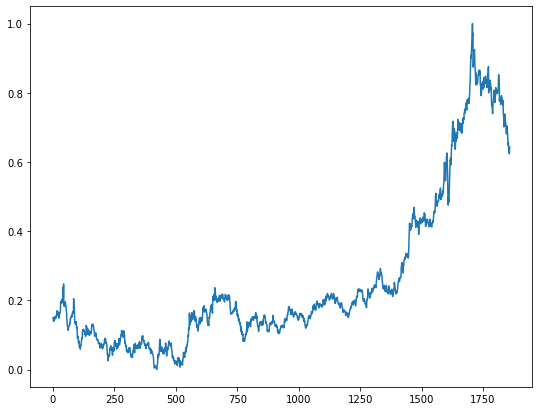

In [9]:
sns.reset_orig()
plt.figure(figsize = (9,7))
#plt.title('Gold Price', fontsize = 24)
plt.plot(y_train['Price'], label = 'trainset')
#plt.plot(y_test['Price'], label = 'testset')

#plt.legend(fontsize = 14)
plt.show()

# XGBoost

In [7]:
import xgboost

In [8]:
model_xgb = xgboost.XGBRegressor().fit(x_train, y_train)
pred_xgb = model_xgb.predict(x_test)

In [9]:
def slide_pred(lag_n, pred):
    prediction = list(pred)
    prediction = prediction[lag_n:]
        
    return prediction

In [10]:
pred_xgb = slide_pred(3, pred_xgb)

In [11]:
y_test = y_test[:-3]

In [12]:
r2_xgb = r2_score(pred_xgb, y_test)
mse_xgb = mean_squared_error(pred_xgb, y_test)

print('R2: ', r2_xgb, '  ;  ', 'MSE: ', mse_xgb)

R2:  0.7988444661085905   ;   MSE:  0.0006239449906168524


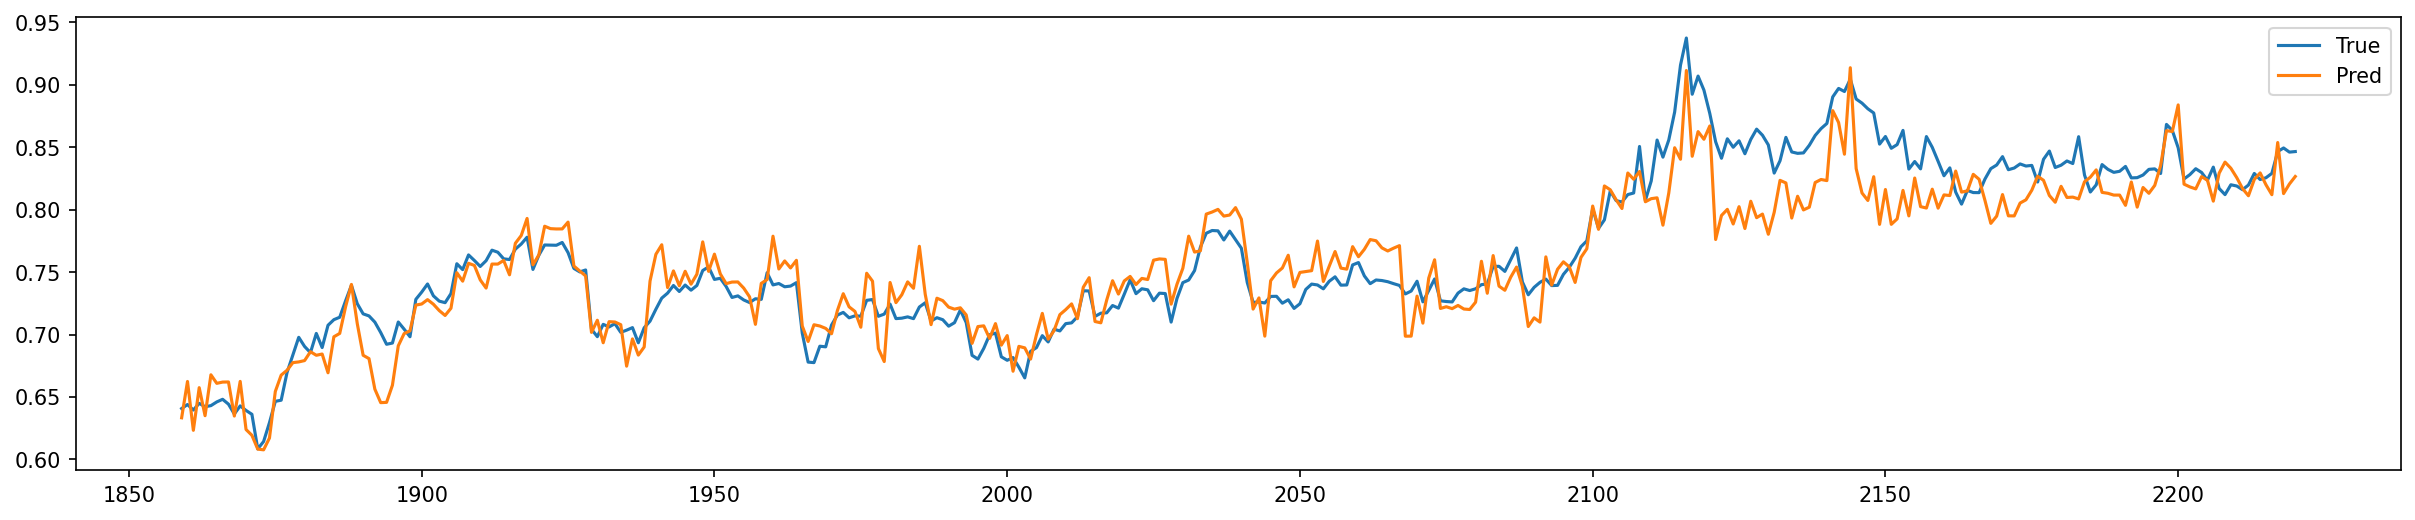

In [13]:
prediction_test = pd.DataFrame(pred_xgb, index=y_test.index)

sns.reset_orig()
plt.figure(figsize = (20,4), dpi=150)

plt.plot(y_test['Price'], label = 'True')
plt.plot(prediction_test, label = 'Pred')

plt.legend()
plt.show()

# Interpretation of XGBoost

In [14]:
import ShapTimeBoosting
from ShapTimeBoosting import supertime, ShapleyValues, TimeImportance, TimeHeatmap

In [15]:
# The training set is evenly divided into 11 parts in the time dimension, 
# and the importance of each part is calculated.
Tn= 10
interp_x= x_train
model = model_xgb

ShapTime_xgb = ShapleyValues(model, interp_x, Tn)

In [16]:
ShapTime_xgb

[-0.03975375331542895,
 -0.05852885961835165,
 -0.06415430498868123,
 -0.024678261808842625,
 -0.039713834955737985,
 -0.028609007233976993,
 -0.017835183969862434,
 0.012688908725825204,
 0.08940522931503496,
 0.17171085565531935]

In [17]:
# name these time periods
time_columns =  ['t0', 't1', 't2', 't3', 't4', 't5', 't6', 't7', 't8', 't9']

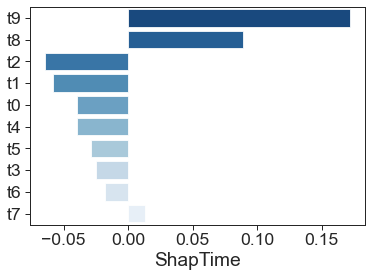

In [18]:
TimeImportance(Tn, ShapTime_xgb, time_columns)

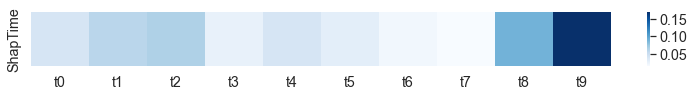

In [19]:
TimeHeatmap(Tn, ShapTime_xgb, time_columns)

# Evaluation of Interpretation

### Feature-Independence

In [20]:
import EvaluationBoosting
from ShapTimeBoosting import FeaIndepenVal, PlotVal

In [21]:
n = 6
Tn = 10
x_train_val = x_train.copy()
y_train = y_train
initial = ShapTime_xgb
model = xgboost.XGBRegressor()

In [22]:
result = FeaIndepenVal(x_train_val, y_train, initial, model, Tn, n, time_columns)

In [23]:
result

,t0,t1,t2,t3,t4,t5,t6,t7,t8,t9
0,-0.039754,-0.058529,-0.064154,-0.024678,-0.039714,-0.028609,-0.017835,0.012689,0.089405,0.171711
1,-0.039749,-0.058523,-0.064124,-0.024731,-0.039708,-0.028637,-0.017778,0.012659,0.089413,0.171710
2,-0.039737,-0.058563,-0.064116,-0.024729,-0.039687,-0.028626,-0.017821,0.012694,0.089401,0.171717
3,-0.039737,-0.058546,-0.064126,-0.024750,-0.039698,-0.028586,-0.017832,0.012689,0.089386,0.171733
4,-0.039804,-0.058490,-0.064067,-0.024759,-0.039688,-0.028598,-0.017924,0.012689,0.089467,0.171705
5,-0.039732,-0.058594,-0.064083,-0.024678,-0.039754,-0.028544,-0.017884,0.012642,0.089438,0.171722
6,-0.039720,-0.058580,-0.064026,-0.024754,-0.039779,-0.028528,-0.017863,0.012664,0.089378,0.171747


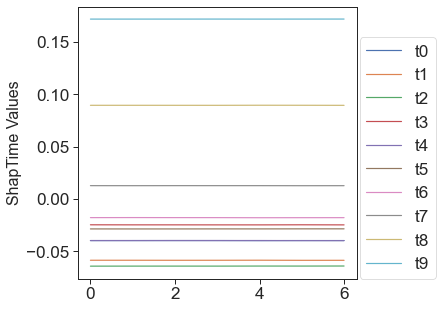

In [24]:
PlotVal(result)

### Sensitivity

In [25]:
situation_0 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  
situation_1 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 7]  
situation_2 = [0, 1, 2, 3, 4, 5, 6, 7, 7, 7]  

In [26]:
total = [situation_0, situation_1, situation_2]
train_eva = train.drop(columns = 'Date')
df_eva = supertime(10, train_eva)
model_eva = xgboost.XGBRegressor()

In [27]:
import EvaluationBoosting
from EvaluationBoosting import evaluation, R2Plot, MSEPlot

In [28]:
r2_results, mse_results = evaluation(df_eva, x_train, y_train, 'Price', model_eva, total)

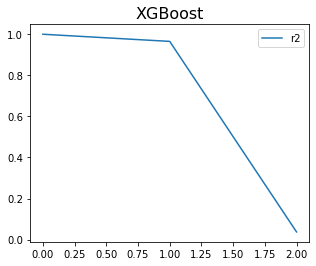

In [29]:
R2Plot(r2_results, 'XGBoost')

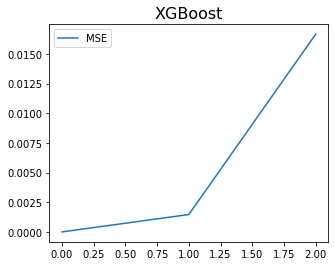

In [30]:
MSEPlot(mse_results, 'XGBoost')

# Improvement

In [31]:
for k in range(Tn):
    exec(f't{k} = supertime(Tn, train)[k]')

In [32]:
check_replist = [t0, t1, t2, t3, t4, t5, t6, t9, t8, t9] 

In [33]:
#check 
check = pd.concat(check_replist, axis = 0)
x_check = check.drop(columns = {'Date','Price'}, axis = 1)
y_check = check.loc[:, ['Price']]

model_check = xgboost.XGBRegressor().fit(x_check, y_check)
pred_check = model_check.predict(x_test)

In [34]:
pred_check = slide_pred(3, pred_check)

In [35]:
r2_check = r2_score(pred_check, y_test)
mse_check = mean_squared_error(pred_check, y_test)

print(r2_check, 'Degree of Improvement: {:.2%}'.format((r2_check-r2_xgb)/abs(r2_xgb)))
print(mse_check, 'Degree of Improvement: {:.2%}'.format((mse_xgb-mse_check)/mse_xgb))

0.8880201294288137 Degree of Improvement: 11.16%
0.0003945834899951421 Degree of Improvement: 36.76%


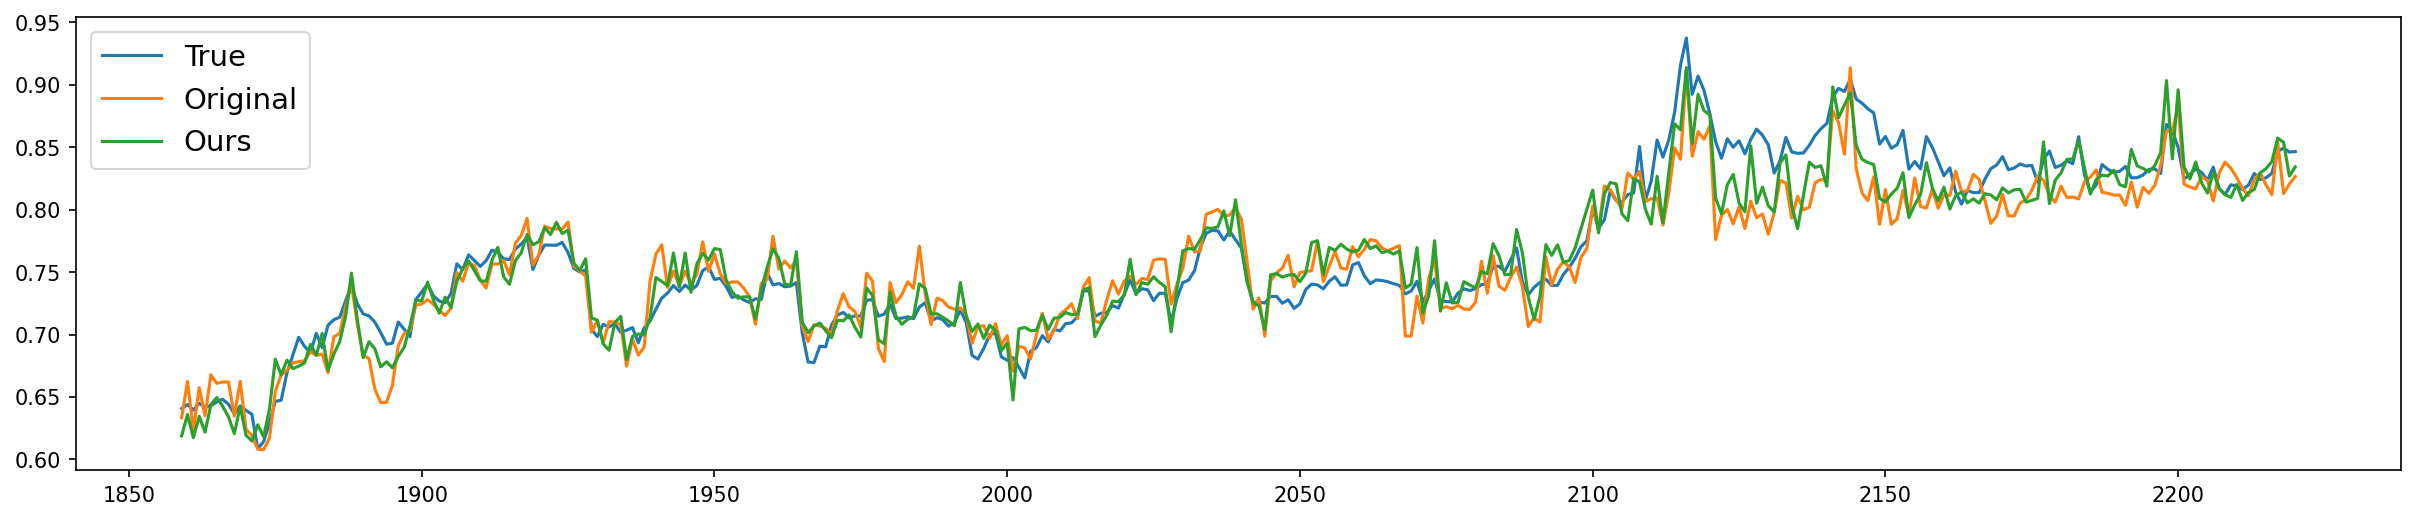

In [36]:
pred_our = pd.DataFrame(pred_check, index=y_test.index)

sns.reset_orig()
plt.figure(figsize = (20,4), dpi=150)

plt.plot(y_test['Price'], label = 'True')
plt.plot(prediction_test, label = 'Original')
plt.plot(pred_our, label = 'Ours')

plt.legend(fontsize = 14)
plt.show()